# Mini-batch Training from Foundations

#### Last Time
[Most recently](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/02_fully_connected_my_reimplementation.ipynb?flush_cache=true) we saw how to implement from scratch both the forward and backward passes of a neural network.

After an extended focus on weight initialization, by which we saw how to derive the basic principals that underpin the now widely-used [Kaiming weight init](02_fully_connected_my_reimplementation.ipynb), we spent some extended time refactoring the code of our forward/backward passes. 

We learned that organizing this code into classes was more concise and interpretable (by human readers) than leaving the logic inside sundry, scattered methods. Finally, we wrapped things up by creating our own `Module()` class that's similar to PyTorch's `nn.Module`, and let our custom loss/linear layer/ReLU classes inherit from it.

According to the rules we set for ourselves at the beginning of this course, we're free to use the PyTorch versions of all classes/functionalities we've thus far implemented from scratch.

#### Minibatch Training
Today we'll implement a model that supports another must-have feature of any deep learning model: the ability to train using mini-batches.

Mini-batches allow us to update our model weights by leveraging the parallel processing capability of Nvidia GPUs to train on several inputs *at the same time*. 

This allows our model to complete a single pass through all the training samples in our dataset in *a much shorter amount of time* than if it were to have to train and update weights for each and every single input in the training set, one at a time!

#### What Components We Implement Here
In building up to being able to create a model that can successfully train on mini-batches, we implement from scratch several other crucial components below. These include:
* Cross entropy loss
* Updating and registering model parameters
* Optimzer classes
* Dataset and Dataloader classes
* Random Sampling
* Setting aside a Validation Set

#### Attribution
Virtually all the code that appears in this notebook is the creation of [Sylvain Gugger](https://www.fast.ai/about/#sylvain) and [Jeremy Howard](https://www.fast.ai/about/#jeremy). The original version of this notebook that they made for the course lecture can be found [here](https://github.com/fastai/course-v3/blob/master/nbs/dl2/03_minibatch_training.ipynb). I simply re-typed, line-by-line, the pieces of logic necessary to implement the functionality that their notebook demonstrated. In some cases I changed the order of code cells and or variable names so as to fit an organization and style that seemed more intuitive to me. Any and all mistakes are my own.

On the other hand, all long-form text explanations in this notebook are solely my own creation. Writing extensive descriptions of the concepts and code in plain and simple English forces me to make sure that I actually understand how they work.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#export
from exports.nb_02 import *
import torch.nn.functional as F

### Preparing the Data
We continue to use the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset as a baseline to test the functionality and performance of all the classes we create from scratch.

In [3]:
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
x_train, y_train, x_valid, y_valid = get_data()

In [5]:
n,m = x_train.shape # 50,000 images x 784 pixels per image
c = int(y_train.max()) + 1 # number of classes in dataset
nh = 50 # size of hidden layers

In [6]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh, n_out)]
    
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [7]:
model = Model(m, nh, c)

In [8]:
pred = model(x_train)

### Cross Entropy Loss

In the previous notebook we used a quick-and-dirty mean squared error loss function just so we could have a simple loss function to use to test whether our model was correctly calculating weight gradients. Now, however, it's time to implement a loss function which is better tailored to the MNIST task, which entails predicting one class (out of ten total) to which a handwriting sample of a single-digit number most likely belongs.

#### Log softmax
To build cross entropy loss, we first calculate the softmax of our activations, $$\textrm{softmax}(x)_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + ... + e^{x_{n-1}}}$$ or more concisely, $$\textrm{softmax}(x)_{i} = \frac{e^{x_{i}}}{\sum_{0\leq{j}\leq{n-1}}e^{x_{j}}}$$

Note that in practice, we need to take the log of the softmax in order to calculate the loss.

In [9]:
def log_softmax(x): return (x.exp()/x.exp().sum(-1,keepdim=True)).log()

In [10]:
pred

tensor([[ 0.0887, -0.0349, -0.0814,  ...,  0.0308, -0.0196, -0.0004],
        [ 0.0576, -0.0033,  0.0132,  ...,  0.0507, -0.0592,  0.0061],
        [ 0.0516, -0.0581,  0.0250,  ...,  0.0023, -0.0396, -0.0962],
        ...,
        [ 0.0841, -0.1409, -0.0611,  ...,  0.0254, -0.0366,  0.0731],
        [-0.0209, -0.0425,  0.0053,  ..., -0.0104,  0.0560,  0.1751],
        [ 0.0554, -0.1532,  0.0325,  ...,  0.0359, -0.1168,  0.0629]],
       grad_fn=<AddmmBackward>)

In [11]:
pred.shape

torch.Size([50000, 10])

In [12]:
pred[0]

tensor([ 0.0887, -0.0349, -0.0814, -0.0429,  0.0312,  0.1822,  0.0856,  0.0308,
        -0.0196, -0.0004], grad_fn=<SelectBackward>)

Our model generates, as predictions, a list of length 10 (the number of categories in MNIST) for each of the 50,000 input images. The problem is, if we just use these lists of ten predictions, we really have no standardized way of ascertaining and comparing the degree to which the model believes that a target image belongs to each of the ten categories.

The softmax function we introduced just above, however, thankfully gives us a way to do this. Softmax will take the list of ten predictions for each image, and turn it into a list of ten probabilities that all sum to 1.

In [16]:
softmax_pred = (pred.exp()/pred.exp().sum(-1,keepdim=True))

In [17]:
softmax_pred[0]

tensor([0.1064, 0.0940, 0.0898, 0.0933, 0.1004, 0.1168, 0.1061, 0.1004, 0.0955,
        0.0973], grad_fn=<SelectBackward>)

In [18]:
softmax_pred[0].sum()

tensor(1., grad_fn=<SumBackward0>)

However, in practice we use the log of the softmax instead of just softmax. Why? We like using logarithms because they have a nice property that lets us use subtraction instead of division. Avoiding division is one surefire way to make our loss calculation more numerically stable. [The answer here](https://discuss.pytorch.org/t/logsoftmax-vs-softmax/21386/4) gives a nice explanation.

In [19]:
logsoftmax_pred = log_softmax(pred)

In [20]:
logsoftmax_pred[0]

tensor([-2.2406, -2.3642, -2.4107, -2.3722, -2.2981, -2.1470, -2.2436, -2.2985,
        -2.3489, -2.3297], grad_fn=<SelectBackward>)

#### To one-hot encode or not to one-hot encode
The cross entropy loss between a one-hot encoded target $x$ and a prediction $p(x)$ generated by a model is $$-\sum_{i=1}^{n}{x_{i}\log{\left(p_{i}(x)\right)}}$$ where each $i$ is one of the one-hot encoded label's $n$ total categories.

In other words, it's the sum of the products of the values at all indices in the label list $x$ with the prediction probabilities at corresponding indices in the prediction list $p(x)$. Recall that the values in $x$ will one or zero since the label for $x$ is one-hot encoded. 

Here's a very intuitive [explanation](https://youtu.be/AcA8HAYh7IE?t=1925) using Excel.

Here's a nice, concrete example. Remember that the first training sample's ground truth label is the '5' digit:

tensor(5)

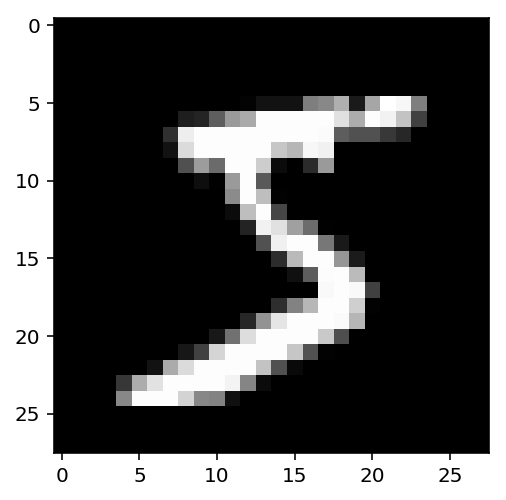

In [26]:
plt.imshow(x_train[0].view(28,28))
y_train[0]

The one-hot encoded label, $x$, for this image is:

In [57]:
label = tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]).float()
label

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

As we just saw above, the log softmax predictions $p(x)$ are:

In [58]:
prediction = logsoftmax_pred[0].detach()
prediction

tensor([-2.2406, -2.3642, -2.4107, -2.3722, -2.2981, -2.1470, -2.2436, -2.2985,
        -2.3489, -2.3297])

According to the formula for cross entropy loss, here's how we calculate the loss for the model's prediction for this image:

In [60]:
-(label * prediction).sum()

tensor(2.1470)

Now you've probably already noticed that our training labels *aren't* actually one-hot encoded:

In [61]:
y_train

tensor([5, 0, 4,  ..., 8, 4, 8])

In [62]:
y_train.shape

torch.Size([50000])

Indeed, each image's label is just a single integer that indicates the correct label for the digit depicted in each image. It turns out that not only do these integers represent actual digit names (which is a nice side-effect of MNIST only having 10 categories), but they also represent the *index* of the correct digit in a one-hot encoded label. i.e. our first training image is a '5' and so there is a one at index 5 in its one-hot encoded label:

```
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
```

When we summed our products in our first attempt at calculating cross entropy loss for the first training image above, you probably noticed that the results of nine of the ten products were *zero*. At this point it should be clear to see that we might as well not waste time computing products that are gonna be zero anyhow.

Indeed, why don't we just calculate the one product that *we know* will return a non-zero value, and not bother with the nine other products and also not bother adding a bunch of zeros to the only non-zero product? 

We can use [numpy-style integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html) to accomplish this. It's as simple as indexing into the prediction list for a single image and grabbing the log softmax value that sits at the index that we know represents the ground truth category of the image.

For example, once again, here's the ground truth label of the first training sample:

In [68]:
correct_label_index = y_train[0]
correct_label_index

tensor(5)

And here's the log softmax value at the 5th index of our model's prediction for this training image, which is the index that corresponds to the correct ground truth label (the number 5, out of numbers 0 through 9, inclusive).

In [69]:
logsoftmax_pred[0][correct_label]

tensor(-2.1470, grad_fn=<SelectBackward>)

If we take this approach, we can rewrite cross-entropy loss in a much more simple way. It's just $$-\log{\left(p_{i}(x)\right)}$$ where $i$ is the index belonging to the target's ground truth class.

Using this formula, here's the categorical cross entropy loss for the first training image:

In [70]:
-logsoftmax_pred[0][correct_label_index]

tensor(2.1470, grad_fn=<NegBackward>)

How wonderful is that! It's the exact same value we got when we summed the ten products of the prediction and its one-hot encoded label, but without all the needless arithmetic. When you're training for hundreds of epochs over potentially millions of images, any optimizations that speed things up on a per-image basis can substantially decrease overall training time!

Note that it's also easy to do this for several images at once. Here's how we'd index into our predictions to find softmax values at the appropriate indices for the first three training images:

In [24]:
y_train[:3]

tensor([5, 0, 4])

In [13]:
logsoftmax_pred[[0,1,2], [5,0,4]]

tensor([-2.3642, -2.2576, -2.2754], grad_fn=<IndexBackward>)

The above indexing mechanism grabs the first three predictions, or lists of length ten, from our tensor that contains these lists of training image category predictions. Then, we go into each of these three lists to grab the log softmax value that is sitting at the index that corresponds to the ground truth category of the image. The first training image is a '5' digit, so we want the log softmax value that's sitting at index 5. The second training image is a '0' digit, so we want to get the log softmax value that is sitting at index 0 of its prediction list of ten log softmax values. And so on and so forth.

#### Negative log-likelihood
Now that we've obtained the softmax log of our predictions we're ready to compute the actual cross-entropy loss.

The negative log-likelihood function is how we do that.

In [14]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [15]:
loss = nll(logsoftmax_pred, y_train)
loss

tensor(2.3182, grad_fn=<NegBackward>)

Before we proceed further, let's pause and remember that thanks to a property of logarithms, we can rewrite the cross entropy function in a more computationally efficient structure (we get rid of the division operation): $$\log{\left(\frac{a}{b}\right)} = \log{\left(a\right)} - \log{\left(b\right)}$$ 

Let's write a new version of `log_softmax()` that takes advantage of this.

In [16]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

Let's ensure that this refactoring is computationally accurate:

In [17]:
test_near(nll(log_softmax(pred), y_train), loss)

We're almost done, but there's one more really helpful tweak that we should build in. 

The [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp) lets us use the following formula to compute the sum of exponentials in a more stable manner: $$\log{\left(\sum_{j=1}^{n}e^{x_{j}}\right)} = \log{\left(e^{a}\sum_{j=1}^{n}e^{x_{j}-a}\right)} = a + \log{\left(\sum_{j=1}^{n}e^{x_{j}-a}\right)}$$ where $a$ is the maximum of all $x_{j}$.

Given that to calculate cross entropy we have to take a sum of exponential terms (as evidenced by the 
```
x.exp().sum(-1,keepdim=True)
``` 
portion of the above `log_softmax()` function), implementing a revised version of our `log_softmax()` function that uses this trick will ensure we avoid an overflow if we have to take the exponential of a big activation.

In [18]:
def logsumexp(x):
    m = x.max(-1)[0] # take the max along the highest dimension of the tensor
    return m + (x - m[:,None]).exp().sum(-1).log()

PyTorch has `logsumexp` as a built-in method so lets compare it to ours:

In [19]:
test_near(logsumexp(pred),   # ours
          pred.logsumexp(-1) # PyTorch's
         )

Here's our final refactored `log_softmax()` with `logsumexp`:

In [20]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

Verify that our latest log_softmax refactoring is still correct:

In [21]:
test_near(nll(log_softmax(pred), y_train), loss)

Verify the same for PyTorch's own functions:

In [22]:
test_near(F.cross_entropy(pred, y_train), loss)

PyTorch combines `F.nll_loss` and `F.log_softmax` into one optimized function called `F.cross_entropy`. 

In [23]:
test_near(F.cross_entropy(pred, y_train), loss)

### Creating a Basic Training Loop

To complete one training loop, our model must be able to perform the following:
1. Get the output of the model on **a batch** of inputs.
* Compare the output to the labels and compute a loss.
* Calculate the gradients of the loss with respect to every parameter in the model.
* Update model parameters with their gradients in order to make the parameters a little bit better.

Below we implement each of these steps in successive lines of code. Further down in this notebook we will see how to refactor into specific classes that manage tasks like storing a dataset, loading the data, etc.

In [24]:
loss_func = F.cross_entropy

In [25]:
#export
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [26]:
bs = 64                # batch size
    
xb = x_train[0:bs]     # a mini-batch from inputs x 
preds = model(xb)      # predictions on items in the mini-batch
preds[0], preds.shape

(tensor([ 0.0942,  0.0491, -0.0652, -0.1084,  0.0840, -0.0479, -0.0238,  0.0033,
          0.0379,  0.0908], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [27]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3140, grad_fn=<NllLossBackward>)

In [28]:
accuracy(preds, yb)

tensor(0.1406)

In [29]:
lr = 0.5   # learning rate
epochs = 1 # number of epochs to train for

In [30]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()

In [31]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2697, grad_fn=<NllLossBackward>), tensor(0.9375))

### Updating model.parameters
In the training loop that we wrote above, layer weights and biases were manually updated and then zeroed out. Instead of this, we can write our model class in such a way, using `self.l1` and `self.l2`, such that we can update all the model's trainable parameters after each forward pass by calling `model.parameters()`.

In [32]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [33]:
model = Model(m,nh,10)

In [34]:
for name, l in model.named_children(): print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [35]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [36]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [37]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad*lr
                model.zero_grad()

In [38]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1160, grad_fn=<NllLossBackward>), tensor(0.9375))

How does PyTorch know what the model's parameters are? It overrides the `__setattr__` function inside the `nn.Module` class in order to register as model parameters the weights and biases inside the submodules (`self.l`, `self.l2`) that were defined in the model's class.

Here's a sample dummy module that mocks up what's going on in `nn.Module`:

In [39]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [40]:
dummy_mdl = DummyModule(m,nh,10)
dummy_mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [41]:
[o.shape for o in dummy_mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### Registering Modules

For deeper models, it's obviously going to be a hassle to declare a `self.<layer_name>` variable for each and every layer in the model. It's probably more convenient to just pass in a list that contains all the layers. E.g. something like
```
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]
self.layers = layers
```

However in order to do this we have to manually register the modules because `nn.Module` won't automatically do so for us.

In [42]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [43]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
    
    def __call__(self,x):
        for l in self.layers: x = l(x)
        return x

In [44]:
model = Model(layers)

In [45]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

#### nn.ModuleList and nn.Sequential

Thankfully both the `nn.ModuleList` and `nn.Sequential` classes can help us do this.

`nn.Sequential` just uses an `nn.ModuleList` object to store the layers. This object automatically registers all layers.

Here's a home-grown clone of `nn.Sequential` that depicts how `nn.ModuleList` is used:

In [46]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [47]:
model = SequentialModel(layers)

In [48]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [49]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0609, grad_fn=<NllLossBackward>), tensor(1.))

Since `nn.Sequential` already does all of the above on its own, we can just use it going forward:

In [50]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [51]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2535, grad_fn=<NllLossBackward>), tensor(0.9375))

In [52]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [53]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0282, grad_fn=<NllLossBackward>), tensor(1.))

### Refactoring the Optimizer

In our training loops above we manually coded the optimization step
```
with torch.no_grad():
    for p in model.parameters(): p -= p.grad*lr
    model.zero_grad()
```

We can refactor this logic into our own `Optimizer` class, which can be much more concisely called from our training loop:
```
opt.step()
opt.zero_grad()
```

In [54]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params, self.lr = list(params), lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad*lr
            
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [55]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [56]:
opt = Optimizer(model.parameters())

In [57]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred,yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [58]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.1486, grad_fn=<NllLossBackward>), tensor(0.9375))

PyTorch's own `optim.SGD` class functions identically to our home-grown `Optimizer` class, with the exception that `optim.SGD` also handles momentum.

In [59]:
#export
from torch import optim

In [60]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [61]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.3366, grad_fn=<NllLossBackward>)

In [62]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [63]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.1586, grad_fn=<NllLossBackward>), tensor(0.9375))

Don't be afraid to include random tests such as this one right below. Although there may well be times when accuracy would dip below `0.7` (due to randomness), having checks like this interspersed throughout your code does much more good than harm, on the whole.

In [64]:
assert acc>0.7

### Dataset

In our early crack at coding up a training loop, we iterated through minibatches of `x` and `y` values separately:
```
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]
```
If, however, we create a `Dataset` class to hold our inputs and labels, we can accomplish those steps at once:

In [65]:
#export
class Dataset():
    def __init__(self, x, y): self.x, self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [66]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [67]:
xb, yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [68]:
model, opt = get_model()

In [69]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs: i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [70]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss, acc

(tensor(0.2065, grad_fn=<NllLossBackward>), tensor(0.9375))

### DataLoader

Our first crack at coding a training loop explicitly iterated over batches using a for-loop that kept track of specific indices. 
```
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs: i*bs+bs]
```

Creating a `DataLoader` class will allow for a more concise implementation thanks to the inclusion of a generator that automatically yields the next batch as soon as needed.

In [71]:
class DataLoader():
    def __init__(self,ds,bs): self.ds, self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [72]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [73]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

tensor(3)

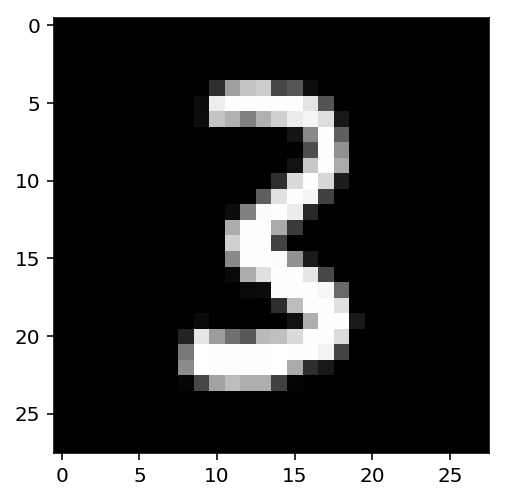

In [74]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [75]:
model,opt = get_model()

In [76]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [77]:
fit()
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0822, grad_fn=<NllLossBackward>), tensor(1.))

### Sampling Should be Random

When training:
* training set should be in *random* order
* that order should differ on each iteration

However for validation:
* validation set should *never* be randomized

In [78]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
    
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i: i+self.bs]

In [79]:
small_ds = Dataset(*train_ds[:10])
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [80]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([1, 9, 0]), tensor([8, 2, 3]), tensor([5, 7, 6]), tensor([4])]

Looks pretty random. Good.

Let's rewrite our `DataLoader` to take advantage of it.

In [81]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [82]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [83]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

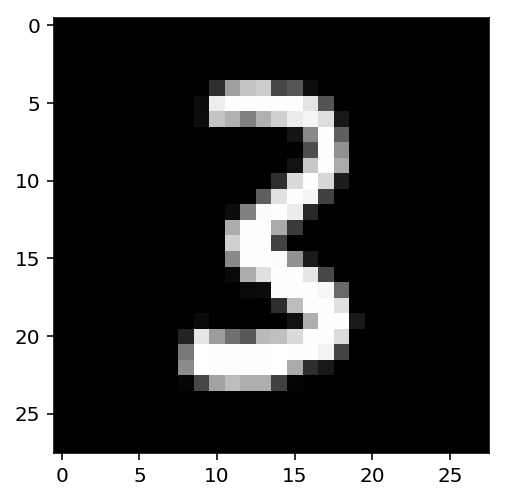

In [84]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(5)

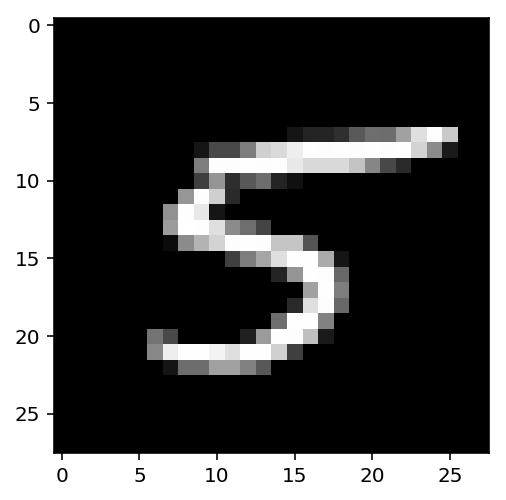

In [85]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(9)

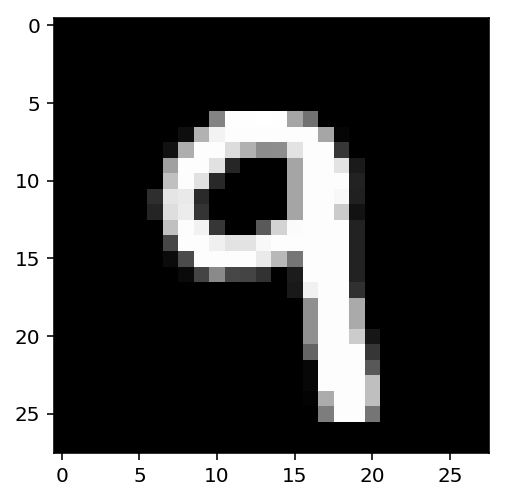

In [86]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [87]:
model, opt = get_model()
fit()
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss, acc

(tensor(0.1490, grad_fn=<NllLossBackward>), tensor(0.9375))

### PyTorch's DataLoader

PyTorch has its own `DataLoader`, `RandomSampler` (for training), and `SequentialSampler` (for validation) classes and we can use them to create our train/valid dataloaders like so:

In [88]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [89]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [90]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1246, grad_fn=<NllLossBackward>), tensor(0.9531))

PyTorch's defaults work fine in most cases. Note that if we pass `num_workers` to PyTorch's `DataLoader`, PyTorch will use multiple threads to call the `Dataset`.

In [91]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [92]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss, acc

(tensor(0.1928, grad_fn=<NllLossBackward>), tensor(0.9531))

### Setting aside a Validation Set

We should **always** have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/) in order to identify whether or not at some point during training our model begins to overfit.

We'll write a training loop once more below, and print out the validation loss at the end of each epoch.

Note that with PyTorch, you should be sure to call `model.train()` *before* training and then call `model.eval()` *before* inference. The reason is that the `nn.BatchNorm2d` and `nn.Dropout` layers' behavior is different depending on whether training or inference is being performed!

In [93]:
def fit (epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train() # Handle proper execution of bn and dropout at training.
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval() # Handle proper execution of bn and dropout at inference.
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

A question to think about: Will the validation metrics printed out here still be correct if batch size varies?

And the answer is that owing to the way that the validation loss/accuracy are calculated the metrics will be incorrect if batch size varies. `tot_loss` and `tot_acc` are augmented each batch. After all batches, they are divided by the number of batches to get the average val loss/accuracy for the entire epoch.
```
for xb,yb in valid_dl:
    pred = model(xb)
    tot_loss += loss_func(pred, yb)
    tot_acc += accuracy(pred, yb)
    .
    .
    .
return tot_loss/nv, tot_acc/nv
```
If batch size varies, and say the final batch is smaller than all the others, the loss/acc of the final batch will be *over*-weighted in the epoch's loss/acc metrics.

Why? Say all batches are size 64 except for the final batch, which is 16. Each batch up to the penultimate batch have an avg loss/acc (for that batch) that's divided by 64. The final batch's avg loss/acc is only divided by 16. 

Now, by averaging the average loss/acc of *each* of the individual batches over the total number of batches, our epoch loss/avg is essentially assuming that each each batch's avg loss/acc is calculated using the same sized denominator (batch size). In other words, `tot_loss`/`tot_acc` assumes that each pred/label pair (or each batch's average loss/acc) contributes equally to the overall epoch average loss/acc. However, we know that for the final batch, this isn't true. The denominator (batch size) is only 16 and because this isn't compensated for, the pred/label pairs in the final batch disproportionally sway the overall average epoch loss/acc.

Here's a simple example to illustrate what's going on.

Say we have three batches, with the first two of size 10 and the last of size 5. And if they have the following accuracies:
$$\frac{5}{10}, \frac{5}{10}, \frac{2}{5}$$ We would expect that the total combined accuracy of all samples would be: $$\frac{5+5+2}{10+10+5} = \frac{12}{25}$$ However, if we calculate the their combined average accuracy using the approach we used to calculate `tot_acc`, we'd calculate a combined average accuracy of $$\frac{\frac{5}{10} + \frac{5}{10} + \frac{2}{5}}{3} = \frac{\frac{14}{10}}{3} = \frac{14}{30}$$ Immediately we notice that $\frac{14}{30}$ is *less than* $\frac{12}{25}$. 

In other words, the 3rd batch's lower accuracy is exerting *too large* an effect on the overall average accuracy calculation -- it is lower, just slightly, than it ought to be. The batch's accuracy of $\frac{2}{5}$ should only contribute to $\frac{5}{25}$ of the epoch's average accuracy (since the batch has only 5 of the 25 total samples), yet our misguided calculation has it influencing $\frac{1}{3}$ of the epoch's average accuracy.

The proper way to calculate the epoch's average accuracy that takes into account the 3rd batch's smaller size relative to the first two batches would be to calculate a weighted average: $$\frac{5}{10}*\frac{10}{25} + \frac{5}{10}*\frac{10}{25} + \frac{2}{5}*\frac{5}{25} = \frac{10}{25} + \frac{2}{25} = \frac{12}{25}$$

`get_dls` will return dataloaders for the training and validation sets:

In [94]:
#export 
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs), 
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Because the validation set has `10,000` items and because we're using a batch size of 128 for running inference on our validation set, if we don't explicitly set `drop_last=True` in our validation data loader, our calculations for validation loss/accuracy will be slightly skewed. 

The last batch will have a size of only `16`. And as explained above, the last batch's loss/acc metrics will thus sway the overall totals more than they should. For the instructional purposes of this notebook, we won't worry about accounting for this in our validation loss/acc calculations at this point.

The `get_dls()` method allows us to now create dataloaders and fit the model, in only *three lines of code*.

In [95]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.2808) tensor(0.9006)
1 tensor(0.1229) tensor(0.9634)
2 tensor(0.1326) tensor(0.9616)
3 tensor(0.1114) tensor(0.9670)
4 tensor(0.1046) tensor(0.9691)


In [96]:
assert acc>0.9

### Export

In [97]:
!python notebook2script_my_reimplementation.py 03_minibatch_training_my_reimplementation.ipynb

Converted 03_minibatch_training_my_reimplementation.ipynb to nb_03.py
